In [1]:
import numpy as np # linear algebra
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

# Random state seed
seed = 1234

In [2]:
def load_dataset():
    train_dataset = h5py.File('/kaggle/input/happy-dataset/train_happy.h5', "r")
    test_dataset = h5py.File('/kaggle/input/happy-dataset/test_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = np.transpose(train_set_y_orig.reshape((1, train_set_y_orig.shape[0])))
    test_set_y_orig = np.transpose(test_set_y_orig.reshape((1, test_set_y_orig.shape[0])))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_X, train_set_y, test_set_X, test_set_y, classes = load_dataset()

def create_validation_set(train_set_X, train_set_y, test_size=0.2, random_state=seed):
    """
    Divides the training set into training and validation set
    
    Input:
    - train_set_X: Training set samples containing only features (no label)
    - train_set_y: Training set labels
    - test_size: (optional) % of training data to be separated as validation data
    
    Output:
    - X_train: Training samples
    - y_train: Training labels
    - X_valid: Validation samples
    - y_valid: Validation labels
    """
    X_train, X_valid, y_train, y_valid = train_test_split(train_set_X, train_set_y, test_size=test_size, random_state=seed)
    print("Train set size:", X_train.shape)
    print("Validation set size:", X_valid.shape)
    return X_train, y_train, X_valid, y_valid

train_X, y_train, valid_X, y_valid = create_validation_set(train_set_X, train_set_y, test_size=0.2)
# Preparing the data
X_train = train_X.reshape(480, 64*64*3)
X_valid = valid_X.reshape(120, 64*64*3)
test_set_X = test_set_X.reshape(150, 64*64*3)

def normalization(x, mu, std):
    """
    Normalization
    
    Input:
    - x: data
    - mu: average
    - std: standard deviation
    
    Output:
    - x_scaled: normalized output
    """
    x_scaled = (x-mu)/std
    return x_scaled

# Normalize the data
mean_X = X_train.mean()
std_X = X_train.std()
X_train_scl = normalization(X_train, mean_X, std_X)
X_valid_scl = normalization(X_valid, mean_X, std_X)
X_test_scl = normalization(test_set_X, mean_X, std_X)

m = X_train.shape[0] # no of training samples
n = X_train.shape[1] # no of features
X_train_app = np.c_[np.ones(m), X_train_scl] # append a column of 1
X_valid_app = np.c_[np.ones(120), X_valid_scl] # append a column of 1
X_test_app = np.c_[np.ones(150), X_test_scl] # append a column of 1
alpha = 1e-3 # learning rate
iters = 1000 # no of iterations

Train set size: (480, 64, 64, 3)
Validation set size: (120, 64, 64, 3)


In [3]:
class LogisticRegression:
    def __init__(self,x,y):      
        self.intercept = np.ones((x.shape[0], 1))  
        self.x = np.concatenate((self.intercept, x), axis=1)
        self.weight = np.zeros(self.x.shape[1])
        self.y = y
        print("size of X", self.x.shape, "\nsize of y",self.y.shape, "type of y", type(self.y), "\nsize of weights", self.weight.shape)
         
    #Sigmoid function
    def sigmoid(self, x, weight):
        z = np.dot(x, weight)
#         a = 1 / (1 + np.exp(-z))
        a = .5 * (1 + np.tanh(.5 * z))
        return a
     
    #calculate the Loss
    def loss(self, h, y):
        epsilon = 1e-10
        J = (-y * np.log(h+epsilon) - (1-y) * np.log(1-h+epsilon)).mean()
        return J
     
    #calculating the gradients
    def gradient_descent(self, X, h, y):
        delJ = np.dot(X.T, (h - y)) / y.shape[0]
        return delJ
 
     
    def fit(self, lr , iterations):
        J = np.zeros(iterations)
        for i in range(iterations):
            sigma = self.sigmoid(self.x, self.weight)
             
            J[i] = self.loss(sigma,self.y)
 
            delJ = self.gradient_descent(self.x , sigma, self.y)
             
            #Updating the weights
            self.weight -= lr * delJ
#             print('fitted successfully to data')
            
        return J
     
    #Method to predict the class label.
    def predict(self, x_new , treshold):
        intercept_new = np.ones((x_new.shape[0], 1))
        x_new = np.concatenate((intercept_new, x_new), axis=1)
        result = self.sigmoid(x_new, self.weight)
#         result = result >= treshold
        y_pred = np.round(result)#np.zeros(result.shape[0])
#         for i in range(len(y_pred)):
#             if result[i] == True: 
#                 y_pred[i] = 1
#             else:
#                 continue
                 
        return y_pred

size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
75.72


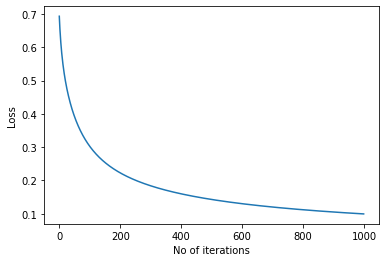

In [4]:
regressor = LogisticRegression(X_train_scl, y_train.flatten())
J = regressor.fit(alpha , iters)
y_pred = regressor.predict(X_test_scl,0.5)

test_acc = (y_pred == test_set_y).sum()/150
print(test_acc)

plt.plot(range(0,iters), J)
plt.ylabel("Loss")
plt.xlabel("No of iterations")
plt.savefig("Loss_vs_iterations.png")
plt.show()

In [5]:
print(J.shape)

(1000,)


learning rate 1e-05
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 72.0
Elapsed time 4.466296434402466


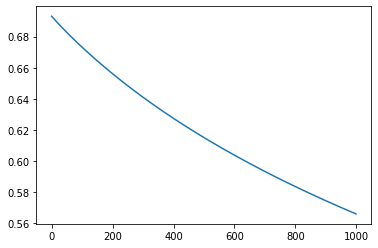



learning rate 5e-05
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 73.2
Elapsed time 4.256048679351807


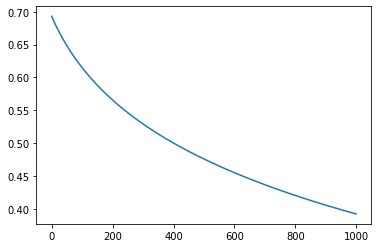



learning rate 0.0001
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 74.04
Elapsed time 4.078680753707886


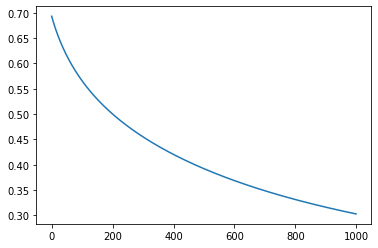



learning rate 0.0005
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.6
Elapsed time 4.2835373878479


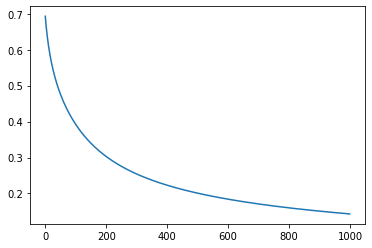



learning rate 0.001
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.72
Elapsed time 5.006356239318848


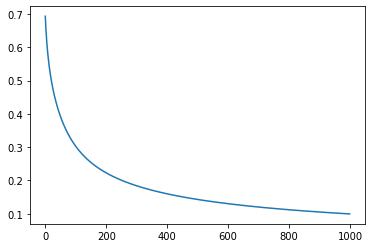



learning rate 0.005
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.72
Elapsed time 4.503736734390259


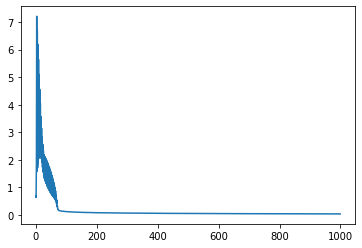



learning rate 0.01
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.84
Elapsed time 4.072738885879517


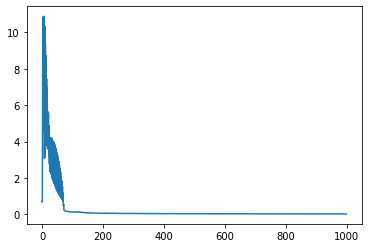



learning rate 0.05
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.36
Elapsed time 4.16383957862854


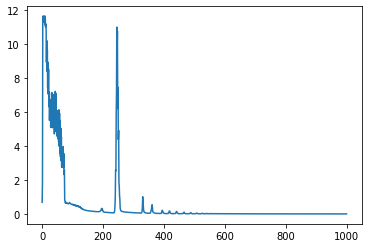



learning rate 0.1
size of X (480, 12289) 
size of y (480,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy 75.12
Elapsed time 4.358670234680176


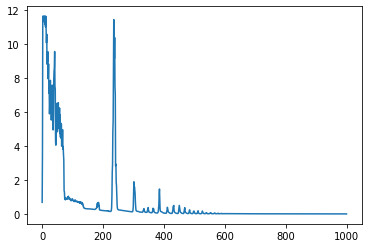

In [6]:
alpha_lr = np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
test_acc_lr=np.zeros(alpha_lr.shape[0])
idx=0
# print(test_acc_list)
elapsed_time = np.zeros(alpha_lr.shape[0])
for lr in alpha_lr:
    elapsed_time[idx] = time.time()
    print("learning rate", lr)
    regressor_lr = LogisticRegression(X_train_scl, y_train.flatten())
    J_lr = regressor_lr.fit(lr , iters)
    y_test_pred_lr = regressor_lr.predict(X_test_scl, 0.5)
    test_acc_lr[idx] = (y_test_pred_lr == test_set_y).sum()/150
    print("test accuracy",test_acc_lr[idx])
    elapsed_time[idx] = time.time() - elapsed_time[idx]
    print("Elapsed time", elapsed_time[idx])
    plt.figure(idx)
    plt.plot(range(0,iters), J_lr)
    plt.show()
    print("\n")
    idx += 1

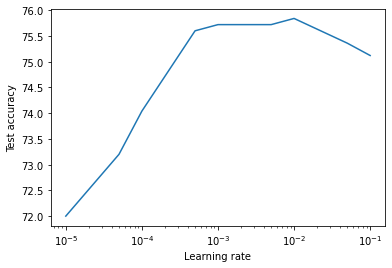

In [7]:
plt.plot(alpha_lr, test_acc_lr)
plt.xscale('log')
plt.ylabel("Test accuracy")
plt.xlabel("Learning rate")
plt.savefig("test_acc_vs_lr.png")
plt.show()

In [8]:
def select_subset_from_dataset(imgs, labels, ratio, shuffle=True, seed=1234):
    """
    Args:
     imgs: numpy array representing the image set from which 
        the selection is made.
     labels: the labels associated with the provided images.
     ratio (optional): portion of the data to be selected. Default: 0.1.
     shuffle (optional): Whether or not to shuffle the data. Default: True.
     seed (optional): seed of the numpy random generator: Default: 1234.

    Return:
     A tuple of 2 elements (select_imgs, select_labels)
     where:
        select_imgs: a numpy array of the selected images.
        select_labels: labels associated with the selected images.

    """
    if shuffle:
        np.random.seed(seed)  # Set the random seed of numpy.
        indices = np.random.permutation(imgs.shape[0])
    else:
        indices = np.arange(imgs.shape[0])
    idx, _ = np.split(indices, [int(ratio*len(indices))])
    select_imgs = imgs[idx]
    tgt = np.array(labels)
    select_labels = tgt[idx]#.tolist()
    return select_imgs, select_labels


select_imgs, select_labels = select_subset_from_dataset(
    X_train_app, y_train, 0.1
)
print("Type of X", type(select_imgs), "Shape:", select_imgs.shape)
print("Type of y", type(select_labels), "Shape:", select_labels.shape)

Type of X <class 'numpy.ndarray'> Shape: (48, 12289)
Type of y <class 'numpy.ndarray'> Shape: (48, 1)


In [9]:
percent_data = np.linspace(0.1, 1.0, 19)
# print(percent_data)
test_acc_pr=np.zeros(percent_data.shape[0])
ix = 0
for pr in percent_data:
    print("training set size", pr)
    pr_train_X, pr_train_y = select_subset_from_dataset(X_train_scl, y_train, ratio=pr)
    regressor_pr = LogisticRegression(pr_train_X, pr_train_y.flatten())
    regressor_pr.fit(alpha , iters)
    y_test_pred_pr = regressor_pr.predict(X_test_scl,0.5)
    test_acc_pr[ix] = (y_test_pred_pr == test_set_y).sum()/150
    print("test accuracy:",test_acc_pr[ix],"\n")
    ix += 1


training set size 0.1
size of X (48, 12289) 
size of y (48,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 74.4 

training set size 0.15000000000000002
size of X (72, 12289) 
size of y (72,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 75.0 

training set size 0.2
size of X (96, 12289) 
size of y (96,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 74.76 

training set size 0.25
size of X (120, 12289) 
size of y (120,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 75.36 

training set size 0.30000000000000004
size of X (144, 12289) 
size of y (144,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 75.36 

training set size 0.35
size of X (168, 12289) 
size of y (168,) type of y <class 'numpy.ndarray'> 
size of weights (12289,)
test accuracy: 75.12 

training set size 0.4
size of X (192, 12289) 
size of y (192,) type of y <class 'numpy.ndarray'> 


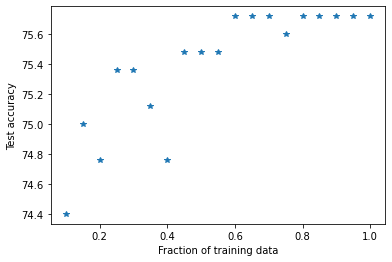

In [10]:
plt.plot(percent_data, test_acc_pr, '*')
plt.xlabel('Fraction of training data')
plt.ylabel("Test accuracy")
plt.savefig("Percentage_Train.png")
plt.show()